### Imports


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

comp='bf1'
import sys  # update paths
sys.path.append('../../')
sys.path.append('../')

import os 
import numpy as np 
import matplotlib.pyplot as plt
import copy
import meas_analysis.handy as hy
import scresonators.fit_resonator.ana_resonator as ana_res
import scresonators.fit_resonator.ana_tls as ana_tls
import seaborn as sns
import scipy.constants as cs
from scipy.optimize import curve_fit

colors = ['#4053d3', '#b51d14', '#ddb310','#658b38','#7e1e9c', '#75bbfd', '#cacaca']
sns.set_palette(colors)

if comp=='shannon':
    pth_base ='/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/'
elif comp=='bf1':
    pth_base='G:/'
elif comp=='vic':
    pth_base='I:/'

folder = 'My Drive/Projects/Materials/'
pth = pth_base+folder
img_pth = pth+'Outputs/Resonators/'

#meas = 'silicon-waffle-sing'
#meas = 'silicon-waffle-1108'
#meas = 'silicon-waffle-phase'
#meas = 'full_qubitB'
meas = 'sil3_vna'

No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
Could not load InstrumentManagerWindow
Could not load TekTDS7104
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [6]:
import yaml

with open('resonator_meas.yaml', 'r') as file:
    sample_dict = yaml.safe_load(file)

matching_keys = [key for key, items in sample_dict.items() for item in items['meas'] if item == meas]
sample = matching_keys[0] if matching_keys else None

ind = sample_dict[sample]['meas'].index(meas)
print(ind)
#data_pth = pth_base+folder+'Data/'+sample_dict[sample]['pth']
data_pth = pth_base+folder+'Data/'+'241125-ResonatorSil3/'


2


In [7]:
sample_dict
params = sample_dict[sample]
params['temp']=0.04 
#slope=params['slope'][ind]

## Sweep power/temp, plot results

### Run sweep 

In [9]:
res_params = ana_res.analyze_sweep_gen(params['dir'][ind], data_pth, name=meas, img_pth=img_pth, plot=True, nfiles=params['nfiles'][ind], meas_type=params['meas_type'][ind], fitphase=True)

Counter()
Counter()


In [10]:


#slope = 0
%matplotlib inline
frac = 7.714986
fnames = ana_res.plot_all(params['dir'][ind], data_pth, output_path=img_pth, max_power=-15, norm=False, half_norm=False, nfiles=params['nfiles'][ind], meas_type=params['meas_type'][ind])#, slope=slope)

Counter()
Counter()


g:\My Drive\Projects\Materials\materials-software\scresonators\fit_resonator\../..\scresonators\fit_resonator\ana_resonator.py:469: SyntaxWarning: invalid escape sequence '\D'
  ax2[0].set_ylabel("$\Delta f/f$ (ppm)")
g:\My Drive\Projects\Materials\materials-software\scresonators\fit_resonator\../..\scresonators\fit_resonator\ana_resonator.py:518: SyntaxWarning: invalid escape sequence '\D'
  ax[1].set_ylabel("$\Delta f/f_0$")
g:\My Drive\Projects\Materials\materials-software\scresonators\fit_resonator\../..\scresonators\fit_resonator\ana_resonator.py:564: SyntaxWarning: invalid escape sequence '\D'
  ax[3].set_ylabel("$\Delta f/f_0$")
g:\My Drive\Projects\Materials\materials-software\scresonators\fit_resonator\../..\scresonators\fit_resonator\ana_resonator.py:623: SyntaxWarning: invalid escape sequence '\m'
  a.set_xlabel("Gap width ($\mu$m)")
g:\My Drive\Projects\Materials\materials-software\scresonators\fit_resonator\../..\scresonators\fit_resonator\ana_resonator.py:671: SyntaxWarni

IndexError: list index out of range

In [43]:
#fnames, res_params = ana_res.analyze_sweep_other(params['dir'][ind], data_pth, output_path=img_pth, max_power=-15, nfiles=params['nfiles'][ind], meas_type=params['meas_type'][ind],slope=slope)#, slope=slope)

#### Reorder the data based on pitch (only run once)

In [44]:

if params['meas_type']=='soc':
    res_params = ana_res.convert_power(res_params) 

params, res_params=ana_res.reorder(params, res_params) # only run once!
params['qc'] = np.array([np.nanmedian(res_params[i]['qc']) for i in range(len(res_params))])
params['qc_err'] = np.array([np.nanmedian(res_params[i]['qc_err']) for i in range(len(res_params))])
params['freqs'] = np.array([np.nanmedian(res_params[i]['freqs']) for i in range(len(res_params))])
params['phs'] = np.array([np.nanmedian(res_params[i]['phs']) for i in range(len(res_params))])

### Power sweep and TLS fits

In [45]:
# adjust power values
nvals =16
atten_inc = 5
pows = np.flip(-np.arange(0,nvals)*atten_inc)
for i in range(len(res_params)) :
    res_params[i]['pow'] = np.array([pows])
print(res_params[0])

{'freqs': array([[5.8912e+09, 5.8912e+09, 5.8912e+09, 5.8912e+09, 5.8912e+09,
        5.8912e+09, 5.8912e+09, 5.8912e+09, 5.8912e+09, 5.8912e+09,
        5.8912e+09, 5.8912e+09, 5.8912e+09, 5.8912e+09, 5.8912e+09,
        5.8912e+09]]), 'phs': array([[ 0.3936,  0.3769,  0.0817,  0.3348,  0.4099, -0.0451,  0.0871,
         0.1287,  0.0853,  0.0345,  0.0515,  0.0605,  0.0648,  0.0679,
         0.0703,  0.0639]]), 'q': array([[346405.3004, 261919.3788, 165052.6629, 133911.9297, 150468.6827,
        174048.6169, 187834.242 , 262778.0971, 310008.5063, 336188.8369,
        349613.7711, 368544.0398, 386751.5338, 409781.367 , 431825.347 ,
        453910.1006]]), 'qi': array([[387523.3722, 289856.8814, 184663.8332, 149807.4856, 167724.5838,
        200425.3492, 219256.7251, 315952.9265, 384338.1796, 426292.005 ,
        449514.8367, 481125.7104, 513381.327 , 552853.1219, 592542.7025,
        635846.033 ]]), 'qc': array([[3015131.6874, 2526737.4772, 1548994.3481, 1191957.1649,
        1341356.09

Error in plotting
Failed!


UnboundLocalError: cannot access local variable 'fnames' where it is not associated with a value

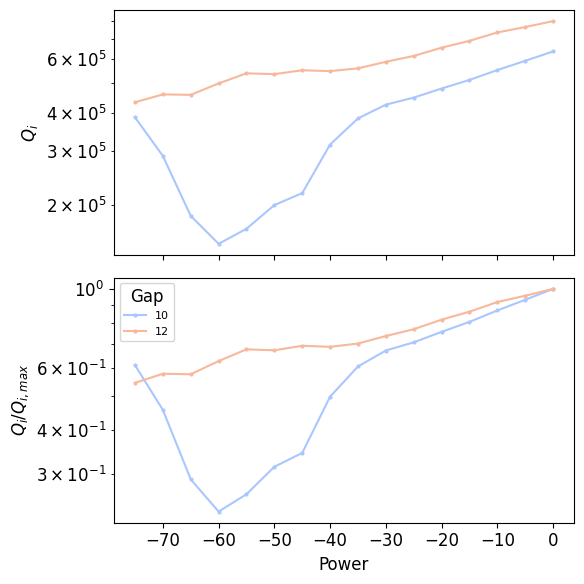

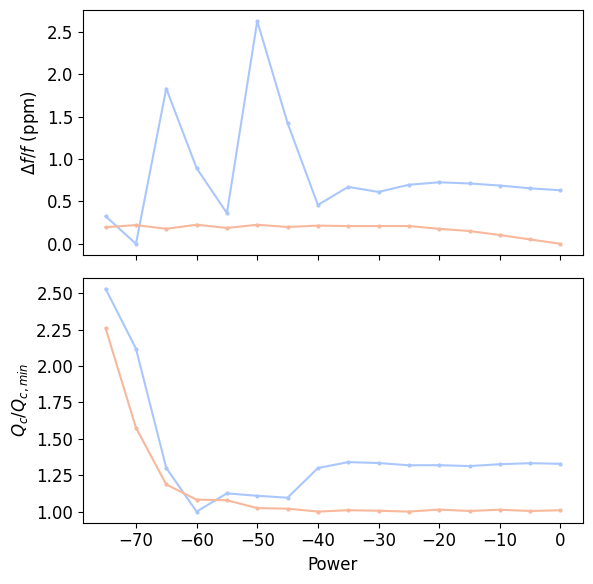

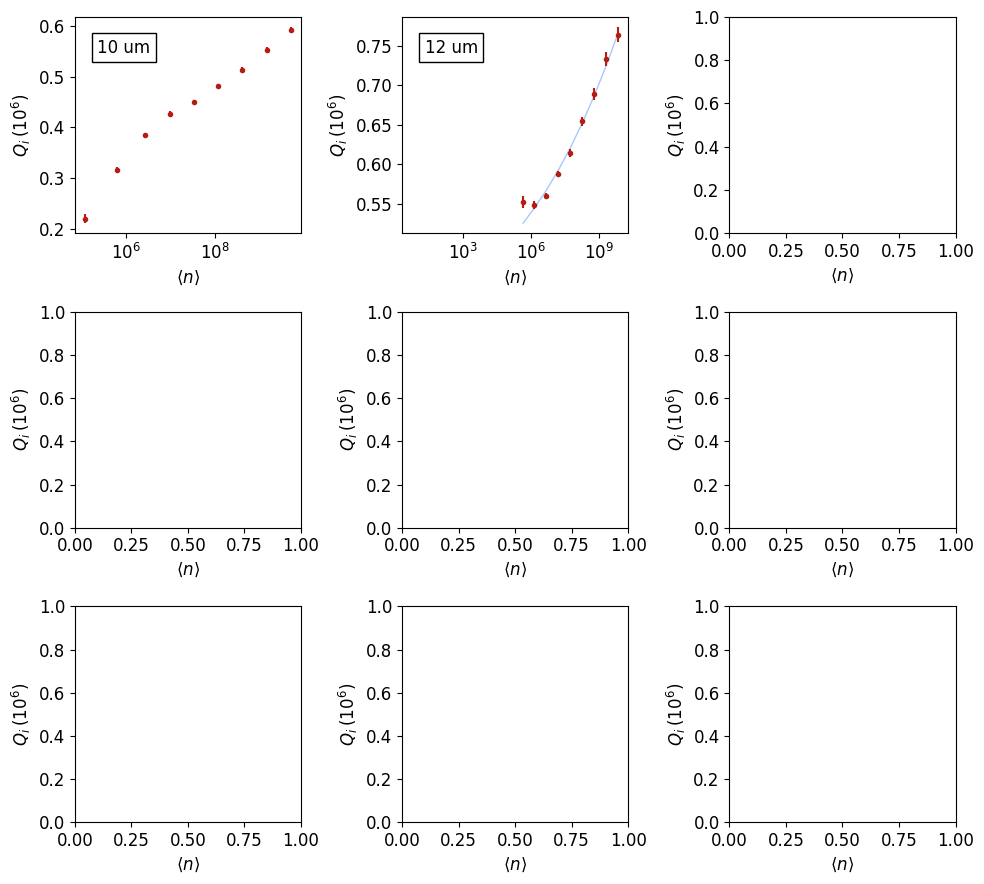

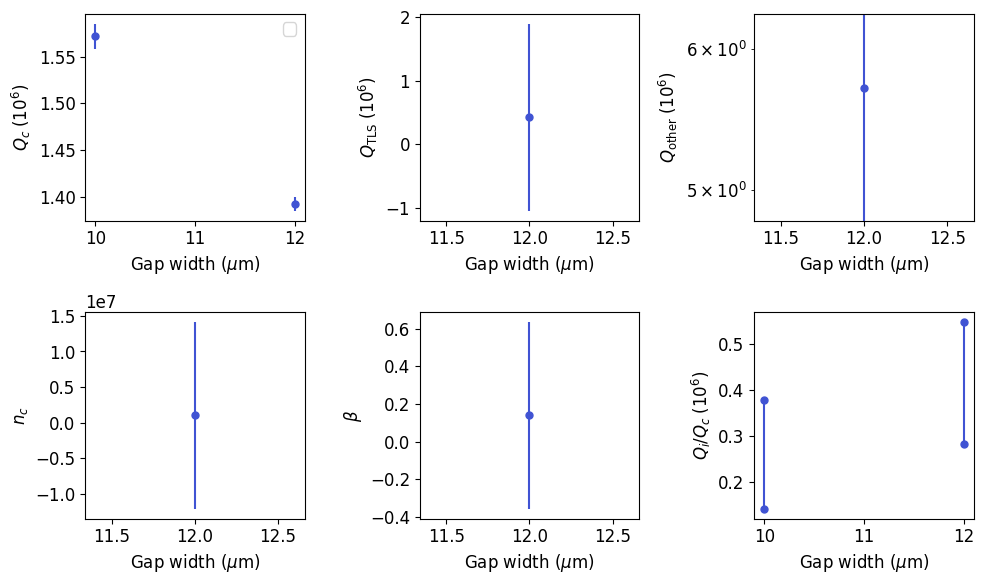

In [48]:
#%matplotlib widget
ana_res.plot_power(res_params, params, img_pth, use_pitch=True)

# min_power = [-135, -135, -100, -135, -135, -135, -100, -130]
# max_power = [24, 18, 0, 35, 37, -30, 18, 23]

#power sweep 8
# min_power = np.array([-70, -60, -70, -60, -70, -70, -70, -70])+10
# max_power = [24, 18, -5, 35, 37, -5, -5, 23]

#power sweep 9
# min_power = np.array([-70, -60, -50, -50, -70, -55, -70, -60])+5
# max_power = [24, 18, 0, 35, 0, 0, 0, 0]

#power sweep10
# min_power = np.array([-70, -65, -65, -55, -70, -60, -70, -60])+5
# max_power = [24, 18, 0, 0, 0, 0, 0, 0]

# power sweep 12
# min_power = np.array([-70, -50, -55, -30, -55, -55, -45, -50])-10
# max_power = [24, 18, 0, 0, 0, 0, 0, 0]

min_power = np.array([-70, -70, -70, -70, -70, -70, -70, -70])+20
max_power = [0, 0, 0, 0, 0, 0, 0, 0]

cfg = ana_tls.fit_qi(res_params, params, img_pth, max_power_vec = max_power, min_power_vec = min_power) 
# params['qtls0'][2] = float('nan')
# params['qother'][2] = float('nan')

ana_tls.plot_res_pars([params], [''],img_pth)
ana_res.plot_res_pars([params], [''], img_pth)
hy.save_np(params, img_pth+'Text/' + params['meas'][ind] + '.yml')


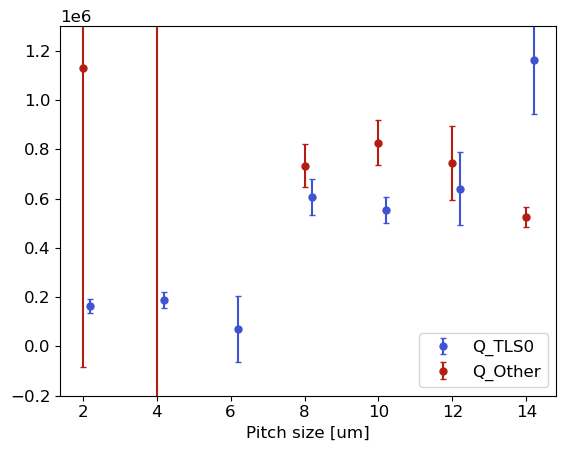

In [125]:
pitch_list = params['pitch']
qtls0 = params['qtls0']
qtls0_err = params['qtls0_err']
qother = params['qother']
qother_err = params['qother_err']

%matplotlib inline
plt.errorbar(np.array(pitch_list)+0.2, qtls0, yerr = qtls0_err, fmt='.', label = 'Q_TLS0', capsize = 2)
plt.errorbar(pitch_list, qother, yerr = qother_err, fmt='.', label = 'Q_Other', capsize = 2)
plt.xlabel('Pitch size [um]')
plt.legend()
plt.ylim(-0.2*10**6, 1.3*10**6)
plt.show()




In [107]:
params

{'atten': -50,
 'dir': [['powersweep3'], ['powersweep5'], ['powersweep6'], ['powersweep1']],
 'flip': True,
 'max_power': 25,
 'meas': ['silicon-no-waffle',
  'silicon-no-waffle_lopower',
  'silicon-no-waffle2',
  'silicon-waffle'],
 'meas_type': ['soc', 'soc', 'soc', 'soc'],
 'min_power': -100,
 'nfiles': [3, 3, 3, 3],
 'pitch': [2, 4, 6, 8, 10, 12, 14, 16],
 'pth': '241104-Resonator/',
 'target_freq': [7, 7.2, 7.5, 7.9, 5.9, 6.2, 6.5, 6.7],
 'temp': 0.04,
 'qc': array([5310493.0988, 3921384.2356, 4750783.911 , 1961581.7718,
        1529335.4791, 4751895.2588, 5009973.0863, 2636164.9255]),
 'qc_err': array([133694.7388, 122886.296 , 114741.6252,  31169.0051,  10620.7044,
         92095.9583, 117262.2053,  48954.572 ]),
 'freqs': array([6.6920e+09, 7.0677e+09, 7.4751e+09, 7.9884e+09, 5.9829e+09,
        6.3210e+09, 6.6800e+09, 6.9927e+09]),
 'phs': array([-0.1632, -0.3034, -0.247 ,  0.0778,  0.0714, -0.2909, -0.2266,
         0.0042]),
 'qtls0': array([         nan,   53592.228 ,  2840

### Plot with different max and min power for each resonator 

Failed!


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


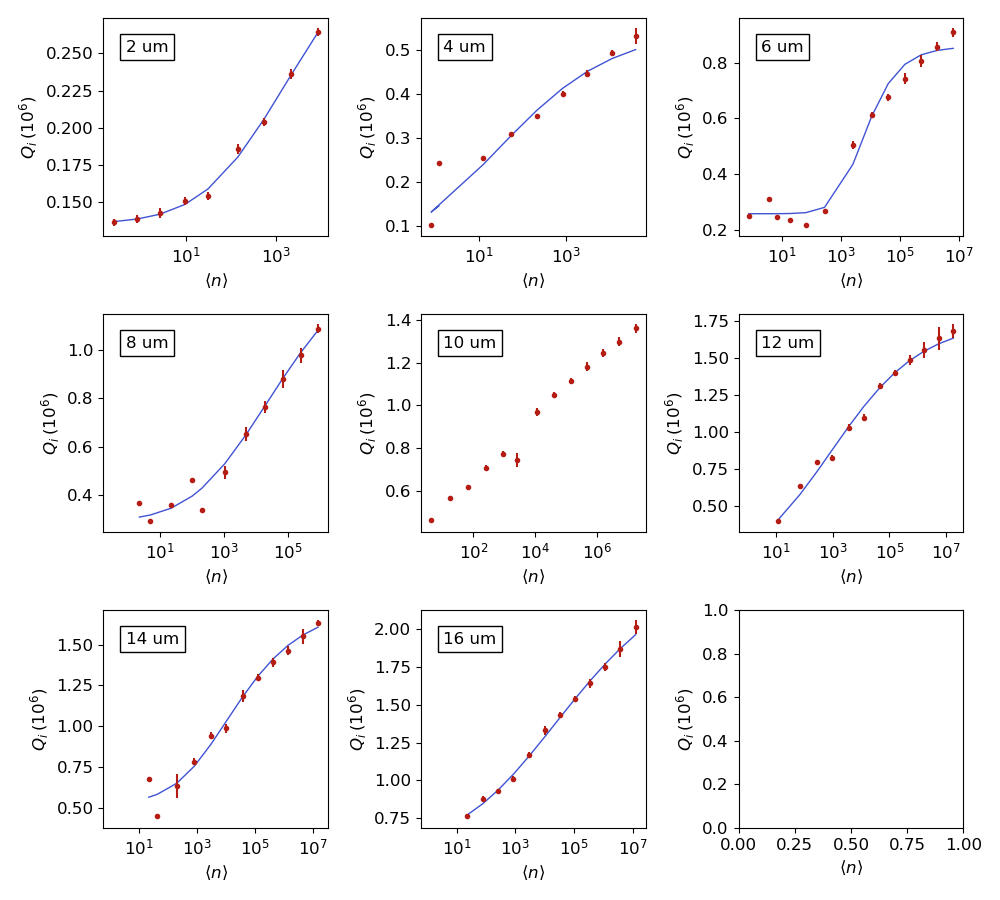

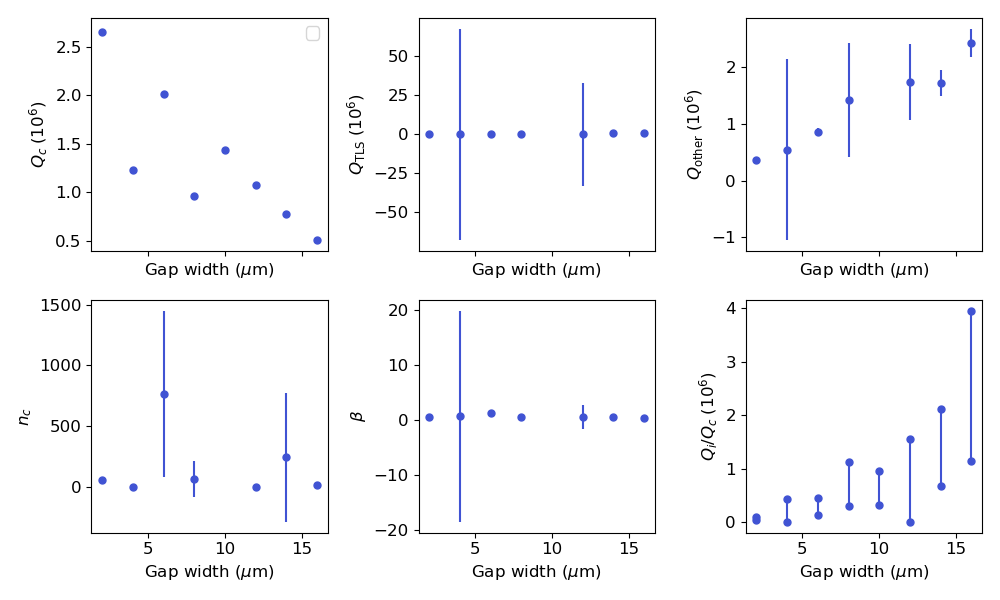

In [70]:
if sample == 'hf3':
    max_power = [-40, -50, -35, -40, -25, -25, -25, -25]

    cfg = ana_tls.fit_qi(res_params, params, img_pth, max_power_vec = max_power) 
    ana_tls.plot_res_pars([params], [''],img_pth)
    #params_nohf_low_pow = copy.deepcopy(params)
    params_hf = copy.deepcopy(params)
else:
    max_power = [-35, -35, -15, -25, -15, -15, -15, -15]
    min_power = [-115, -115, -115, -115, -100, -95, -90, -90]
    
    cfg = ana_tls.fit_qi(res_params, params, img_pth, max_power_vec = max_power, min_power_vec = min_power) 
    ana_tls.plot_res_pars([params], [''],img_pth)
    params_no_hf = copy.deepcopy(params)

### Print out info for running scans

In [9]:
lw=[]
freq =[]
print('linewidth')
for i in range(len(params['freqs'])):
    q = 1/(1/params['qi0'][i]+1/params['qc'][i])
    lw.append(params['freqs'][i]/q)
    freq.append(params['freqs'][i])

print(lw)
print(freq)

linewidth
[62108.84999872619, 31754.88651060028, 35928.47570952304, 29346.31301041099, 14571.561073889929, 14732.344817108129, 17533.865679245962, 19348.403941294877]
[6336553046.740015, 6692450581.395647, 7056426236.336695, 7382931608.965666, 5516761886.202525, 5820846804.326765, 6091775267.869023, 6376982672.309232]


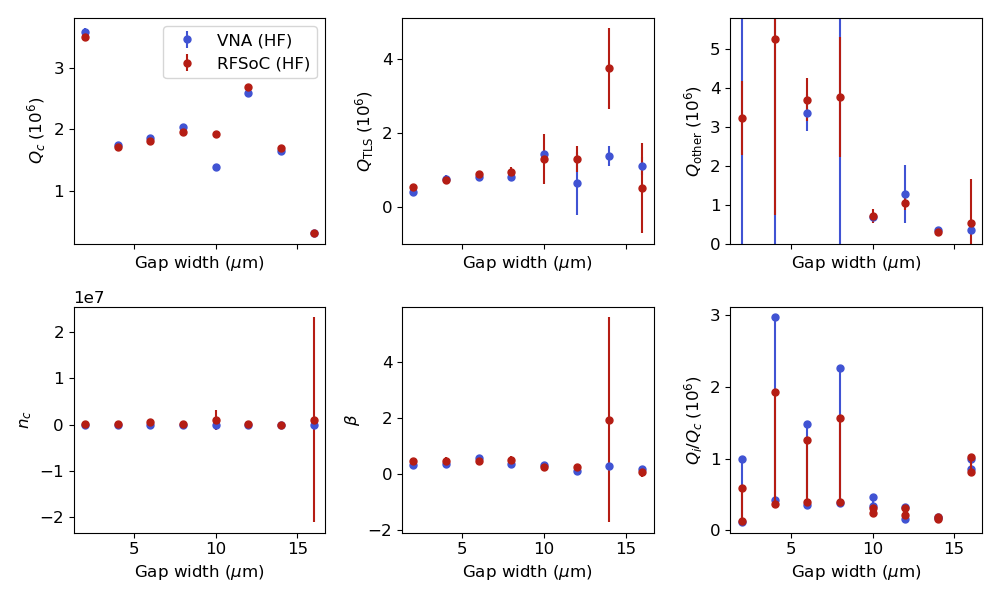

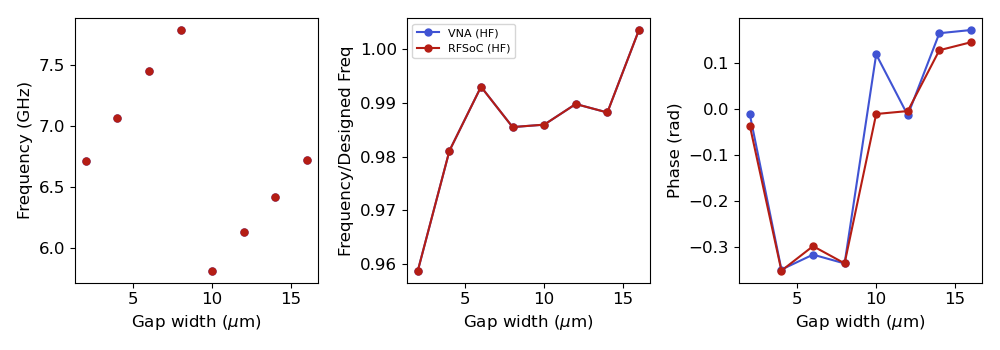

In [ ]:
%matplotlib widget
#pnames = ['240814-2','240725','240729-2', '240729-4']
#labs = ['ScalinQ (No HF)', 'SLab (No HF)', 'SLab (HF)', 'RFSoC (HF)'] 

#pnames = ['240729-2', '240729-3']
pnames = ['240729-3', '240820_soc']
labs = ['VNA (HF)', 'RFSoC (HF)'] 
plist =[]
for p in pnames:
    plist.append(hy.load(img_pth +'Text/'+ p + '.yml'))

ana_tls.plot_res_pars(plist, labs,img_pth)
ana_res.plot_res_pars(plist, labs,img_pth)


## Single resonators

### Get list of resonators

In [ ]:
# Grab list of resonators following corect format in directory. 

pattern0 = r'res_(\d+)_\d{2,5}dbm'
resonators, file_list0 = ana_res.get_resonators(directories[0],pth, pattern0)

pattern = 'res_{:d}_'.format(resonators[0]) + '(\d{2,3})dbm'
file_list = ana_res.get_resonator_power_list(pattern, file_list0)

### Fit slope for RFSoC phase correction

In [ ]:
pth = r'/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/My Drive/Projects/Materials/Data/240816-Resonator'

plt.figure()
data, attrs = hy.prev_data(pth, 'test2')
plt.plot(data['xpts'][0], data['phases'][0])
slope, ofs = np.polyfit(data['xpts'][0], np.unwrap(data['phases'][0]), 1)
data['phases'] = np.unwrap(data['phases'][0]) - slope * data['xpts'][0]-ofs

print(slope)

data['phases']

In [ ]:
# Grab list of resonators following corect format in directory. 

pth = r'/Users/sph/Library/CloudStorage/GoogleDrive-circuitqed@gmail.com/My Drive/Projects/Materials/Data/240818-Resonator/'

#directories = ['240816-Resonator/powersweep3']
directories = ['powersweep2']
pattern0 = r'res_(\d+)_\d'
resonators, file_list = ana_res.get_resonators(directories[0],pth, pattern0)

In [ ]:
fname =  'res_6423_4096_wideright'
data, attrs = hy.prev_data(pth+directories[0], fname)

data.keys()

Single resonator

In [ ]:
data = ana_res.grab_data(pth+directories[0], file_list[4], 'soc', slope=slope)
#ana_res.plot_raw_data(data)
output = ana_res.fit_resonator(data, fname, img_pth, plot=True)   

In [ ]:
sorted_file_list = sorted(file_list)
print(sorted_file_list)

In [ ]:
file_list[12]

In [ ]:
%matplotlib widget

for i in range(len(file_list)):
    #try:
    data = ana_res.grab_data(pth+directories[0], file_list[i])       
    ana_res.plot_raw_data(data)
    #output = ana_res.fit_resonator(data, file_list[i], output_path, 'png')    
    #except: 
    #    print('fit failed')  
7.714986

In [ ]:

pth = '../../../../JJ_fab/Coherence Sample/Resonators Measurement/240725/data/power_sweep5'
fname = 'res_7083855_60dbm_wide'
data = ana_res.grab_data(pth, fname)
output = ana_res.fit_resonator(data, fname, img_pth, plot=True)   
ana_res.plot_raw_data(data)

## Temp sweep

In [ ]:
# Initialize the directories list for a temperature sweep 
temps, directories = ana_res.get_temp_list(pth_base, max_temp=1500)
res_params = ana_res.analyze_sweep(directories)

ana_res.plot_power_temp(res_params,i,params,img_pth)